# Sequence of Persistence Descriptors from a set of trajectories

## 1. Importing modules and setting parameters

In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import scipy.spatial.distance as dist
from navground import sim, core
from tslearn.generators import random_walks
from tslearn import metrics
import seaborn as sns
import gudhi
from gudhi.wasserstein import wasserstein_distance
from navground.sim.ui.video import display_video_from_run, record_video_from_run
from functools import partial
from IPython.display import Image

# Create folder to save bottleneck distances between matching diagrams
import os
os.makedirs("Corridor_matrices_consecutive", exist_ok=True)
os.makedirs("plots_consecutive", exist_ok=True)
title_1 = "Wasserstein distance"
title_2 = "sum matching difference"
title_3 = "wasserstein"

In [2]:
parser = argparse.ArgumentParser(description='Simulation Parameters')
parser.add_argument('--length', type=float, default=10.0, help='Length of the environment')
parser.add_argument('--width', type=float, default=10.0, help='Width of the environment')
parser.add_argument('--num_runs', type=int, default=1, help='Number of simulation runs')
parser.add_argument('--num_steps', type=int, default=100, help='Number of steps in the simulation')
parser.add_argument('--time_step', type=float, default=0.1, help='Time step for the simulation')
parser.add_argument('--num_agents', type=int, default=10, help='Number of agents in the simulation')
parser.add_argument('--max_speed', type=float, default=1.0, help='Maximum speed of agents')
parser.add_argument('--optimal_speed', type=float, default=1.0, help='Maximum speed of agents')
parser.add_argument('--radius', type=float, default=0.25, help='Radius of agents')
parser.add_argument('--safety_margin', type=float, default=0.1, help='Safety margin for agents')
parser.add_argument('--behavior', type=str, default='HL', help='Behavior type')
parser.add_argument('--max_edge_length', type=float, default=100.0, help='Maximum edge length in the simplicial complex')
parser.add_argument('--epsilon', type=int, default=50, help='time differences for matching and bottleneck distance computation')

_StoreAction(option_strings=['--epsilon'], dest='epsilon', nargs=None, const=None, default=50, type=<class 'int'>, choices=None, required=False, help='time differences for matching and bottleneck distance computation', metavar=None)

In [3]:
args = parser.parse_args([
        '--length', '15.0',
        '--width', '3.5',
        '--num_runs', '12',
        '--num_steps', '800',
        '--time_step', '0.1',
        '--num_agents', '10',
        '--max_speed', '1.66',
        '--optimal_speed', '1.2',
        '--radius', '0.4',
        '--safety_margin', '0.1',
        '--behavior', 'HL',
        '--max_edge_length', '22.0',
        '--epsilon', '50',
    ])

## Prepare custom distance

Normalize angle with respect to other variables.

In [4]:
def normangle(angle):
    result = np.mod(angle, 2 * np.pi)
    result[result > np.pi] -= 2 * np.pi
    return result

Create custom distance to compare positions.

In [5]:
def custom_distance(vector1, vector2, weights):
    result = 0
    if weights[0] != 0:
        px_diff = np.abs(vector1[0] - vector2[0])
        px_diff = np.minimum(px_diff, args.length - px_diff)
        result += px_diff * weights[0]
    if weights[1] != 0:
        py_diff = np.abs(vector1[1] - vector2[1])
        result += py_diff * weights[1]
    if weights[2] != 0:
        pr_diff = np.abs(vector1[2] - vector2[2])
        pr_diff = np.minimum(pr_diff, 2 * np.pi - pr_diff)
        result += pr_diff * weights[2]
    return result

In [6]:
weights = np.array([1,5,0.5])

In [7]:
custom_distance_with_param = partial(custom_distance, weights=weights)

### Prepare bottleneck and partial matchings computations

In [8]:
import perdiver.perdiver as perdiver

Dynamic time warping distance matrices computation

In [9]:
def dismat_from_step(trajectories, step):
    num_agents = trajectories.shape[1]
    dismat = np.zeros((num_agents, num_agents))
    for a in range(num_agents):
        for b in range(a):
            # _, tsim = metrics.dtw_path_from_metric(trajectories[steps,a,:], trajectories[steps,b,:], metric=custom_distance_with_param)
            tsim = custom_distance_with_param(trajectories[step, a,:], trajectories[step,b,:])
            dismat[a,b] = tsim
            dismat[b,a] = tsim
        # end for 
    # end for
    return dismat
# end def 

Computation of distance matrix list

In [10]:
def compute_dismat_list(trajectories, args):
    # Set up arguments
    sim_steps = args.num_steps
    # Iteration computing distance matrices
    dismat_list = []
    for step in range(args.num_steps):
        dismat_list.append(dismat_from_step(trajectories, step))
    # end for iterations
    return dismat_list
# def compute_distmat_list

Computation of persistence from distance matrix

In [11]:
def pers_from_dismat(dismat, max_edge_length):
    rips_complex = gudhi.RipsComplex(distance_matrix=dismat, max_edge_length=max_edge_length,sparse=None)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=0)
    simplex_tree.compute_persistence()
    pers = simplex_tree.persistence_intervals_in_dimension(0)
    pers[np.isinf(pers[:, 1]), 1] = max_edge_length
    return pers
# end def

In [12]:
help(wasserstein_distance)

Help on function wasserstein_distance in module gudhi.wasserstein.wasserstein:

wasserstein_distance(X, Y, matching=False, order=1.0, internal_p=inf, enable_autodiff=False, keep_essential_parts=True)
    Compute the Wasserstein distance between persistence diagram using Python Optimal Transport backend.
    Diagrams can contain points with infinity coordinates (essential parts).
    Points with (-inf,-inf) and (+inf,+inf) coordinates are considered as belonging to the diagonal.
    If the distance between two diagrams is +inf (which happens if the cardinalities of essential
    parts differ) and optimal matching is required, it will be set to ``None``.
    
    :param X: The first diagram.
    :type X: n x 2 numpy.array
    :param Y:  The second diagram.
    :type Y: m x 2 numpy.array
    :param matching: if ``True``, computes and returns the optimal matching between X and Y, encoded as
        a (n x 2) np.array  [...[i,j]...], meaning the i-th point in X is matched to
        the j-t

Computation of wasserstein matchings

In [13]:
def compute_wasserstein_matching(dismat_list, args):
    wasserstein_matching = []
    sim_steps = len(dismat_list)-1
    pers_list = []
    for dismat in dismat_list:
        pers_list.append(pers_from_dismat(dismat, args.max_edge_length))
    # end for
    for i in range(args.epsilon,iterations):
        # bottle.append(gudhi.bottleneck_distance(pers_list[i-epsilon], pers_list[i]))
        bottle.append(wasserstein_distance(pers_list[i-args.epsilon], pers_list[i], internal_p=1))
    # end for
    bottle = np.array(bottle)
    bottle = np.pad(bottle,pad_width=(0,args.num_steps - sim_steps)) #Fill with 0s if needed
    return bottle

Computation of matching bottleneck signal

In [14]:
def compute_matching_bottleneck_signal(distmat_list, args, epsilon=50):
    # Set up arguments
    sim_steps = args.num_steps
    iterations = sim_steps - (args.embedding_length - 1) * args.time_delay
    # Iteration computing matching diagrams
    matching_signal = []
    for i in range(epsilon,iterations):  
        matching_diagram = perdiver.get_matching_diagram(dismat_list[i-epsilon], dismat_list[i])
        matching_signal.append(mean_abs_diff_matching(matching_diagram))
    # end for
    return matching_signal

List of behaviors:
* HL
* ORCA
* SocialForce

## 2. HL behavior

### Running the experiment

In [15]:
yaml = f"""
runs: {args.num_runs}
steps: {args.num_steps}
time_step: {args.time_step}
save_directory: ''
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
scenario:
  type: Corridor
  length: {args.length}
  width: {args.width}
  groups:
    -
      type: thymio
      number: {args.num_agents}
      radius: {args.radius}
      control_period: 0.1
      speed_tolerance: 0.02
      kinematics:
        type: 2WDiff
        wheel_axis: 0.094
        max_speed: {args.max_speed}
      behavior:
        type: {args.behavior}
        optimal_speed: {args.optimal_speed}
        horizon: 5.0
        safety_margin: {args.safety_margin}
      state_estimation:
        type: Bounded
        range: 5.0
"""
experiment = sim.load_experiment(yaml)
experiment.run()
runs = experiment.runs

In [16]:
display_video_from_run(run=runs[1], factor=3.0, fps=10)

### Dataset signals

In [17]:
positions_changes = []
for r in range(args.num_runs):
    trajectories = runs[r].poses.copy()
    diff_trajectories = np.abs(trajectories[:-args.epsilon] - trajectories[args.epsilon:])
    A = np.abs(diff_trajectories[:,:,0]-args.length)
    diff_trajectories[:,:,0] = np.minimum(diff_trajectories[:,:,0], A)
    positions_changes.append(np.sum(diff_trajectories, axis=1).transpose())
# end for 
positions_changes_all = np.vstack([positions_changes])
quartile_positions_HL = np.percentile(positions_changes_all, [25, 50, 75], axis=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


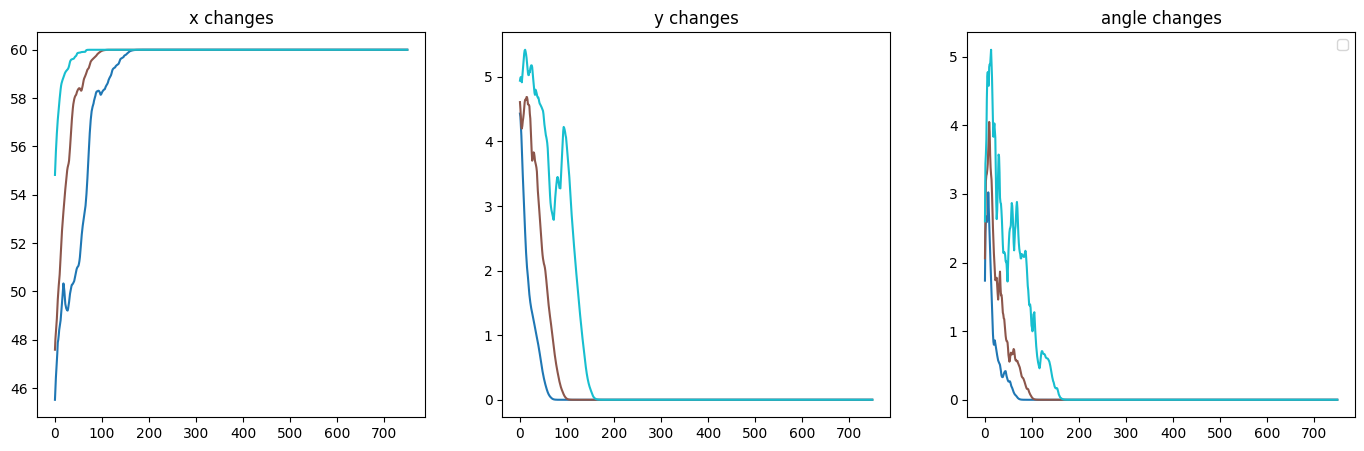

In [18]:
fig, ax = plt.subplots(ncols=3, figsize=(17,5))
cmap = plt.cm.get_cmap('tab10', 3)
indices = np.arange(quartile_positions_HL.shape[2])
for j in range(3):
    for i in range(3):
        ax[j].plot(indices, quartile_positions_HL[i,j], color=cmap(i))
    # for
plt.legend()
ax[0].set_title("x changes")
ax[1].set_title("y changes")
ax[2].set_title("angle changes")
plt.savefig(f"plots_consecutive/positions_corridor_HL.png")

### Computing the matching signals for each run

In [20]:
distance_diff_all = []
bottle_all = []
bottle_matching_all = []
for r in range(args.num_runs):
    # Compute distance matrix list
    trajectories = runs[r].poses.copy()
    trajectories[:,:,2] = normangle(trajectories[:,:,2]) 
    dismat_list = compute_dismat_list(trajectories, args)
    # Compute sum of differences between matrices
    #distance_diff_all.append(compute_dismat_differences(trajectories, dismat_list, args))
    # Compute bottleneck distances
    bottle_all.append(compute_bottleneck(trajectories, dismat_list, args))
    # Compute matching bottleneck distances
    bottle_matching_all.append(compute_matching_bottleneck_signal(dismat_list, args))
# end for
# Turn into numpy arrays
distdiff_HL = np.vstack(distance_diff_all)
bottle_HL = np.vstack(bottle_all)
bottle_matching_HL = np.vstack(bottle_matching_all)
# Save into file
np.save('Corridor_matrices/distdiff_HL.npy', distdiff_HL)
np.save('Corridor_matrices/bottle_HL.npy', bottle_HL)
np.save('Corridor_matrices/matching_bottleneck_HL.npy', bottle_matching_HL)
# Get quartiles
quartile_distdiff_HL = np.percentile(distdiff_HL, [25, 50, 75], axis=0)
quartile_bottle_HL = np.percentile(bottle_HL, [25, 50, 75], axis=0)
quartile_matching_HL = np.percentile(bottle_matching_HL, [25, 50, 75], axis=0)

NameError: name 'compute_bottleneck' is not defined

Plot results for both bottleneck and matching bottleneck for comparison

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5))
cmap = plt.cm.get_cmap('tab10', 3)
for j, quartile_list in enumerate([quartile_distdiff_HL, quartile_bottle_HL, quartile_matching_HL]):
    indices = np.arange(quartile_list.shape[1])
    for i in range(3):
        ax[j].plot(indices, quartile_list[i], color=cmap(i))
    # for
# for
plt.legend()
ax[0].set_title("Distance matrix differences")
ax[1].set_title(title_1)
ax[2].set_title(title_2)
plt.savefig(f"plots_consecutive/{title_3}_corridor_HL.png")

## 3. ORCA behavior

In [ ]:
args.behavior = 'ORCA'

### Running the experiment

In [ ]:
yaml = f"""
runs: {args.num_runs}
steps: {args.num_steps}
time_step: {args.time_step}
save_directory: ''
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
scenario:
  type: Corridor
  length: {args.length}
  width: {args.width}
  groups:
    -
      type: thymio
      number: {args.num_agents}
      radius: {args.radius}
      control_period: 0.1
      speed_tolerance: 0.02
      kinematics:
        type: 2WDiff
        wheel_axis: 0.094
        max_speed: {args.max_speed}
      behavior:
        type: {args.behavior}
        optimal_speed: {args.optimal_speed}
        horizon: 5.0
        safety_margin: {args.safety_margin}
      state_estimation:
        type: Bounded
        range: 5.0
"""
experiment = sim.load_experiment(yaml)
experiment.run()
runs = experiment.runs

In [ ]:
display_video_from_run(run=runs[0], factor=3.0, fps=10)

### Dataset signals

In [ ]:
positions_changes = []
for r in range(args.num_runs):
    trajectories = runs[r].poses.copy()
    diff_trajectories = np.abs(trajectories[:-args.epsilon] - trajectories[args.epsilon:])
    A = np.abs(diff_trajectories[:,:,0]-args.length)
    diff_trajectories[:,:,0] = np.minimum(diff_trajectories[:,:,0], A)
    positions_changes.append(np.sum(diff_trajectories, axis=1).transpose())
# end for 
positions_changes_all = np.vstack([positions_changes])
quartile_positions_ORCA = np.percentile(positions_changes_all, [25, 50, 75], axis=0)

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(17,5))
cmap = plt.cm.get_cmap('tab10', 3)
indices = np.arange(quartile_positions_ORCA.shape[2])
for j in range(3):
    for i in range(3):
        ax[j].plot(indices, quartile_positions_ORCA[i,j], color=cmap(i))
    # for
plt.legend()
ax[0].set_title("x changes")
ax[1].set_title("y changes")
ax[2].set_title("angle changes")
plt.savefig(f"plots_consecutive/positions_corridor_ORCA.png")

### Computing the matching signals for each run

In [ ]:
distance_diff_all = []
bottle_all = []
bottle_matching_all = []
for r in range(args.num_runs):
    # Compute distance matrix list
    trajectories = runs[r].poses.copy()
    trajectories[:,:,2] = normangle(trajectories[:,:,2]) 
    dismat_list = compute_dismat_list(trajectories, args)
    # Compute sum of differences between matrices
    distance_diff_all.append(compute_dismat_differences(trajectories, dismat_list, args))
    # Compute bottleneck distances
    bottle_all.append(compute_bottleneck(trajectories, dismat_list, args))
    # Compute matching bottleneck distances
    bottle_matching_all.append(compute_matching_bottleneck_signal(dismat_list, args))
# end for
# Turn into numpy arrays
distdiff_ORCA = np.vstack(distance_diff_all)
bottle_ORCA = np.vstack(bottle_all)
bottle_matching_ORCA = np.vstack(bottle_matching_all)
# Save into file
np.save('Corridor_matrices/distdiff_ORCA.npy', distdiff_ORCA)
np.save('Corridor_matrices/bottle_ORCA.npy', bottle_ORCA)
np.save('Corridor_matrices/matching_bottleneck_ORCA.npy', bottle_matching_ORCA)
# Get quartiles
quartile_distdiff_ORCA = np.percentile(distdiff_ORCA, [25, 50, 75], axis=0)
quartile_bottle_ORCA = np.percentile(bottle_ORCA, [25, 50, 75], axis=0)
quartile_matching_ORCA = np.percentile(bottle_matching_ORCA, [25, 50, 75], axis=0)

Plot results for both bottleneck and matching bottleneck for comparison

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5))
cmap = plt.cm.get_cmap('tab10', 3)
for j, quartile_list in enumerate([quartile_distdiff_ORCA, quartile_bottle_ORCA, quartile_matching_ORCA]):
    indices = np.arange(quartile_list.shape[1])
    for i in range(3):
        ax[j].plot(indices, quartile_list[i], color=cmap(i))
    # for
# for
plt.legend()
ax[0].set_title("Distance matrix differences")
ax[1].set_title(title_1)
ax[2].set_title(title_2)
plt.savefig(f"plots_consecutive/{title_3}_corridor_ORCA.png")

## 4. SocialForce behavior

In [ ]:
args.behavior = 'SocialForce'

### Running the experiment

In [ ]:
yaml = f"""
runs: {args.num_runs}
steps: {args.num_steps}
time_step: {args.time_step}
save_directory: ''
record_pose: true
record_twist: true
record_collisions: true
record_deadlocks: true
scenario:
  type: Corridor
  length: {args.length}
  width: {args.width}
  groups:
    -
      type: thymio
      number: {args.num_agents}
      radius: {args.radius}
      control_period: 0.1
      speed_tolerance: 0.02
      kinematics:
        type: 2WDiff
        wheel_axis: 0.094
        max_speed: {args.max_speed}
      behavior:
        type: {args.behavior}
        optimal_speed: {args.optimal_speed}
        horizon: 5.0
        safety_margin: {args.safety_margin}
      state_estimation:
        type: Bounded
        range: 5.0
"""
experiment = sim.load_experiment(yaml)
experiment.run()
runs = experiment.runs

In [ ]:
display_video_from_run(run=runs[0], factor=3.0, fps=10)

### Dataset signals

In [ ]:
positions_changes = []
for r in range(args.num_runs):
    trajectories = runs[r].poses.copy()
    diff_trajectories = np.abs(trajectories[:-args.epsilon] - trajectories[args.epsilon:])
    A = np.abs(diff_trajectories[:,:,0]-args.length)
    diff_trajectories[:,:,0] = np.minimum(diff_trajectories[:,:,0], A)
    positions_changes.append(np.sum(diff_trajectories, axis=1).transpose())
# end for 
positions_changes_all = np.vstack([positions_changes])
quartile_positions_SF = np.percentile(positions_changes_all, [25, 50, 75], axis=0)

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(17,5))
cmap = plt.cm.get_cmap('tab10', 3)
indices = np.arange(quartile_positions_SF.shape[2])
for j in range(3):
    for i in range(3):
        ax[j].plot(indices, quartile_positions_SF[i,j], color=cmap(i))
    # for
plt.legend()
ax[0].set_title("x changes")
ax[1].set_title("y changes")
ax[2].set_title("angle changes")
plt.savefig(f"plots_consecutive/positions_corridor_SF.png")

### Computing the matching and bottleneck signals for each run

In [ ]:
distance_diff_all = []
bottle_all = []
bottle_matching_all = []
for r in range(args.num_runs):
    # Compute distance matrix list
    trajectories = runs[r].poses.copy()
    trajectories[:,:,2] = normangle(trajectories[:,:,2]) 
    dismat_list = compute_dismat_list(trajectories, args)
    # Compute sum of differences between matrices
    distance_diff_all.append(compute_dismat_differences(trajectories, dismat_list, args))
    # Compute bottleneck distances
    bottle_all.append(compute_bottleneck(trajectories, dismat_list, args))
    # Compute matching bottleneck distances
    bottle_matching_all.append(compute_matching_bottleneck_signal(dismat_list, args))
# end for
# Turn into numpy arrays
distdiff_SF = np.vstack(distance_diff_all)
bottle_SF = np.vstack(bottle_all)
bottle_matching_SF = np.vstack(bottle_matching_all)
# Save into file
np.save('Corridor_matrices/distdiff_SF.npy', distdiff_SF)
np.save('Corridor_matrices/bottle_SF.npy', bottle_SF)
np.save('Corridor_matrices/matching_bottleneck_SF.npy', bottle_matching_SF)
# Get quartiles
quartile_distdiff_SF = np.percentile(distdiff_SF, [25, 50, 75], axis=0)
quartile_bottle_SF = np.percentile(bottle_SF, [25, 50, 75], axis=0)
quartile_matching_SF = np.percentile(bottle_matching_SF, [25, 50, 75], axis=0)

Plot results for both bottleneck and matching bottleneck for comparison

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5))
cmap = plt.cm.get_cmap('tab10', 3)
for j, quartile_list in enumerate([quartile_distdiff_SF, quartile_bottle_SF, quartile_matching_SF]):
    indices = np.arange(quartile_list.shape[1])
    for i in range(3):
        ax[j].plot(indices, quartile_list[i], color=cmap(i))
    # for
# for
plt.legend()
ax[0].set_title("Distance matrix differences")
ax[1].set_title(title_1)
ax[2].set_title(title_2)
plt.savefig(f"plots_consecutive/{title_3}_corridor_SF.png")

## 5. Behaviors comparison

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5))

indices = np.arange(quartile_distdiff_HL.shape[1])
# confidence distdiff
ax[0].fill_between(indices, quartile_distdiff_HL[0], quartile_distdiff_HL[2], color='blue', alpha=.3)
ax[0].fill_between(indices, quartile_distdiff_ORCA[0], quartile_distdiff_ORCA[2], color='red', alpha=.3)
ax[0].fill_between(indices, quartile_distdiff_SF[0], quartile_distdiff_SF[2], color='green', alpha=.3)
# Bottleneck distdiff
indices = np.arange(quartile_distdiff_HL.shape[1])
ax[0].plot(indices, quartile_distdiff_HL[1], color='blue', label='HL')
ax[0].plot(indices, quartile_distdiff_ORCA[1], color='red', label='ORCA')
ax[0].plot(indices, quartile_distdiff_SF[1], color='green', label='SF')
# confidence bottleneck
indices = np.arange(quartile_bottle_HL.shape[1])
ax[1].fill_between(indices, quartile_bottle_HL[0], quartile_bottle_HL[2], color='blue', alpha=.3)
ax[1].fill_between(indices, quartile_bottle_ORCA[0], quartile_bottle_ORCA[2], color='red', alpha=.3)
ax[1].fill_between(indices, quartile_bottle_SF[0], quartile_bottle_SF[2], color='green', alpha=.3)
# Bottleneck distance
ax[1].plot(indices, quartile_bottle_HL[1], color='blue', label='HL')
ax[1].plot(indices, quartile_bottle_ORCA[1], color='red', label='ORCA')
ax[1].plot(indices, quartile_bottle_SF[1], color='green', label='SF')
# confidence matchings
ax[2].fill_between(indices, quartile_matching_HL[0], quartile_matching_HL[2], color='blue', alpha=.3)
ax[2].fill_between(indices, quartile_matching_ORCA[0], quartile_matching_ORCA[2], color='red', alpha=.3)
ax[2].fill_between(indices, quartile_matching_SF[0], quartile_matching_SF[2], color='green', alpha=.3)
# Bottleneck distance
indices = np.arange(quartile_matching_HL.shape[1])
ax[2].plot(indices, quartile_matching_HL[1], color='blue', label='HL')
ax[2].plot(indices, quartile_matching_ORCA[1], color='red', label='ORCA')
ax[2].plot(indices, quartile_matching_SF[1], color='green', label='SF')
plt.legend()
ax[0].set_title("Distance differences")
ax[1].set_title(title_1)
ax[2].set_title(title_2)
plt.tight_layout()
plt.savefig(f"plots_consecutive/{title_3}_corridor_compare.png")

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(13,4))
# Bottleneck distance
indices = np.arange(quartile_positions_HL.shape[2])
for j in range(3):
    ax[j].fill_between(indices, quartile_positions_HL[0,j], quartile_positions_HL[2,j], color="blue", alpha=0.3)
    ax[j].fill_between(indices, quartile_positions_ORCA[0,j], quartile_positions_ORCA[2,j],color="red", alpha=0.3)
    ax[j].fill_between(indices, quartile_positions_SF[0,j], quartile_positions_SF[2,j], color="green", alpha=0.3)
    ax[j].plot(indices, quartile_positions_HL[1,j], color="blue")
    ax[j].plot(indices, quartile_positions_ORCA[1,j], color="red")
    ax[j].plot(indices, quartile_positions_SF[1,j], color="green")
    # end for
# end for
plt.legend()
ax[0].set_title("x changes")
ax[1].set_title("y changes")
ax[2].set_title("angle changes")
plt.tight_layout()
plt.savefig(f"plots_consecutive/positions_corridor_compare.png")